# Symptom-Based Disease Classification using BioBERT

# *Dataset used: UCI ML Drug Review Dataset (Kaggle)*

In [ ]:
!pip install transformers
!pip install opendatasets
import opendatasets as od
from transformers import BertModel, BertTokenizer
import pandas as pd
from tqdm import tqdm
import torch.nn as nn
import torch
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import AdamW
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score
import logging
import matplotlib.pyplot as plt

# Setting up the model and the dataset, leveraging GPU usage:

In [ ]:
# Setup
torch.manual_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

DATASET_URL = 'https://www.kaggle.com/datasets/jessicali9530/kuc-hackathon-winter-2018'

# Defining the Loading and splitting function for the dataset

In [ ]:
# Data loading function
def load_data(dataset_url, sample_size=5000):
    od.download(dataset_url)
    kaggle_train = pd.read_csv('/content/kuc-hackathon-winter-2018/drugsComTrain_raw.csv')
    kaggle_test = pd.read_csv('/content/kuc-hackathon-winter-2018/drugsComTest_raw.csv')
    main_x = list(pd.concat([kaggle_train['review'], kaggle_test['review']], axis=0, ignore_index=True))[:sample_size]
    main_y = list(pd.concat([kaggle_train['condition'], kaggle_test['condition']], axis=0))[:sample_size]
    return main_x, main_y

# Define Preprocessing (tokenization, setting max lengths for the model input) Functions and Loading the Data into the Model

In [ ]:
# Data preprocessing function
def preprocess_data(x, y, tokenizer, test_size=0.10, val_split=0.5, batch_size=128):
    vocab = list(Counter(y).keys())
    i_to_x = {i: vocab[i] for i in range(len(vocab))}
    x_to_i = {vocab[i]: i for i in range(len(vocab))}

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=0)
    x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=val_split, random_state=0)

    x_train = tokenizer(x_train, truncation=True, max_length=128, padding=True, return_tensors='pt').to(device)
    y_train = torch.tensor([x_to_i[j] for j in y_train], dtype=torch.long).to(device)
    train_dataset = TensorDataset(x_train['input_ids'], x_train['attention_mask'], x_train['token_type_ids'], y_train)
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    x_test = tokenizer(x_test, truncation=True, max_length=128, padding=True, return_tensors='pt').to(device)
    y_test = torch.tensor([x_to_i[j] for j in y_test], dtype=torch.long).to(device)
    test_dataset = TensorDataset(x_test['input_ids'], x_test['attention_mask'], x_test['token_type_ids'], y_test)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

    x_val = tokenizer(x_val, truncation=True, max_length=128, padding=True, return_tensors='pt').to(device)
    y_val = torch.tensor([x_to_i[j] for j in y_val], dtype=torch.long).to(device)
    val_dataset = TensorDataset(x_val['input_ids'], x_val['attention_mask'], x_val['token_type_ids'], y_val)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

    return train_dataloader, val_dataloader, test_dataloader, vocab, i_to_x, x_to_i

# Initializing the model (using BioBERT since it is better for medical tasks)
* We had to tone the model by a lot, since Colab wouldn't allow us to train the model with full-blown constraints
* Using Batch Size 8 (recommended is 128), so our model is very toned down but performs much better than other approaches

In [ ]:
# Constants
BATCH_SIZE = 8
BERT_MODEL = 'dmis-lab/biobert-base-cased-v1.2'
LEARNING_RATE = 3e-5
EPOCHS = 5

# DrugClassifier Class

* Pretrained BioBERT model (bert layer): Extracts contextual embeddings from input text.

* Dropout layer (dropout with rate = 0.1): Helps prevent overfitting by randomly deactivating neurons during training.

* Fully connected layers (lin1 and lin2):

 * lin1: Projects BERT’s output to a 128-dimensional representation.

 * lin2: Maps the 128D representation to the final vocabulary size (number of drug classes).

* Forward Pass: Extracts features from BERT, applies dropout, and passes through linear layers for classification.

In [ ]:
# Enhanced model with dropout
class DrugClassifier(nn.Module):
    def __init__(self, vocab_size, dropout_rate=0.1):
        super(DrugClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(BERT_MODEL)
        self.dropout = nn.Dropout(dropout_rate)
        self.lin1 = nn.Linear(self.bert.config.hidden_size, 128)
        self.lin2 = nn.Linear(128, vocab_size)

    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(input_ids=input_ids, attention_mask=attention_mask, return_dict=False)
        x = self.dropout(pooled_output)
        x = self.lin1(x)
        x = self.lin2(x)
        return x

# EarlyStopping Class

The EarlyStopping class monitors validation loss and stops training when no improvement is observed for patience consecutive epochs.

* Key Parameters:

 * patience=3: Stops training if the validation loss doesn’t improve for 3 consecutive epochs.

 * min_delta=0: Defines the minimum change in loss required to reset patience.

Benefit: Helps prevent overfitting by stopping training at the optimal point.

In [ ]:
# Early stopping class
class EarlyStopping:
    def __init__(self, patience=3, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

# Load and Preprocess Data

In [ ]:
# Load and preprocess data
main_x, main_y = load_data(DATASET_URL)
tokenizer = BertTokenizer.from_pretrained(BERT_MODEL)
train_dataloader, val_dataloader, test_dataloader, vocab, i_to_x, x_to_i = preprocess_data(main_x, main_y, tokenizer)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: kushrevankar
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/jessicali9530/kuc-hackathon-winter-2018


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.11k [00:00<?, ?B/s]

# Train the model on the processed data

In [ ]:
# Initialize model, optimizer, and loss
model = DrugClassifier(len(vocab)).to(device)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Training loop with enhancements
best_model = {'accuracy': -1, 'epoch': -1, 'model': {}, 'optimizer': {}}
early_stopping = EarlyStopping(patience=3)

train_losses, val_losses, train_accs, val_accs = [], [], [], []
for epoch in range(EPOCHS):
    logger.info(f"Epoch: {epoch+1}/{EPOCHS}")
    losses, accuracies, f1_scores = [], [], []
    model.train()
    for input_ids, attention_mask, token_type_ids, labels in tqdm(train_dataloader, desc=f"Training Epoch {epoch+1}", bar_format="{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}]"):
        out = model(input_ids=input_ids.to(device), attention_mask=attention_mask.to(device))
        loss = loss_func(out, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        pred = torch.max(out, dim=1, keepdim=True)[1].view(-1).to(torch.float32).to(device)
        acc = accuracy_score(pred.tolist(), labels.tolist())
        f1 = f1_score(pred.tolist(), labels.tolist(), average='weighted')
        losses.append(loss.item())
        accuracies.append(acc)
        f1_scores.append(f1)

    train_loss = sum(losses) / len(losses)
    train_acc = sum(accuracies) / len(accuracies)
    train_f1 = sum(f1_scores) / len(f1_scores)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    logger.info(f"Train Loss: {train_loss:.4f} | Train Accuracy: {train_acc:.4f} | Train F1: {train_f1:.4f}")

    val_losses_epoch, val_accuracies, val_f1 = [], [], []
    model.eval()
    with torch.no_grad():
        for input_ids, attention_mask, token_type_ids, labels in tqdm(val_dataloader, desc="Validating", bar_format="{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}]"):
            pred = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = loss_func(pred, labels)
            pred = torch.max(pred, dim=1, keepdim=True)[1].view(-1).to(torch.float32)
            acc = accuracy_score(pred.tolist(), labels.tolist())
            f1 = f1_score(pred.tolist(), labels.tolist(), average='weighted')
            val_losses_epoch.append(loss.item())
            val_accuracies.append(acc)
            val_f1.append(f1)

    val_loss = sum(val_losses_epoch) / len(val_losses_epoch)
    val_acc = sum(val_accuracies) / len(val_accuracies)
    val_f1_avg = sum(val_f1) / len(val_f1)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    logger.info(f"Dev Loss: {val_loss:.4f} | Dev Accuracy: {val_acc:.4f} | Dev F1: {val_f1_avg:.4f}")

    early_stopping(val_loss)
    if early_stopping.early_stop:
        logger.info("Early stopping triggered!")
        break

    if best_model['accuracy'] < val_acc:
        best_model['accuracy'] = val_acc
        best_model['epoch'] = epoch + 1
        best_model['model'] = model.state_dict()
        best_model['optimizer'] = optimizer.state_dict()

pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

Training Epoch 1:   0%|          | 0/36 [00:00<?]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Validating: 100%|██████████| 2/2 [00:01<00:00]


# Save the best model (for further reuse without training)

In [ ]:
# Save the best model
torch.save({
    'accuracy': best_model['accuracy'],
    'epoch': best_model['epoch'],
    'model': best_model['model'],
    'optimizer': best_model['optimizer']
}, './best_model6')

# Evaluating the model

In [ ]:
# Load and test the best model
model_path = './best_model6'
checkpoint = torch.load(model_path)
model.load_state_dict(checkpoint['model'])
optimizer.load_state_dict(checkpoint['optimizer'])

test_accuracies, test_f1_scores, test_losses = [], [], []
model.eval()
with torch.no_grad():
    for input_ids, attention_mask, token_type_ids, labels in tqdm(test_dataloader, desc="Testing", bar_format="{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}]"):
        pred = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = loss_func(pred, labels)
        pred = torch.max(pred, dim=1, keepdim=True)[1].view(-1).to(torch.float32)
        acc = accuracy_score(pred.tolist(), labels.tolist())
        f1 = f1_score(pred.tolist(), labels.tolist(), average='weighted')
        test_accuracies.append(acc)
        test_f1_scores.append(f1)
        test_losses.append(loss.item())

test_loss = sum(test_losses) / len(test_losses)
test_acc = sum(test_accuracies) / len(test_accuracies)
test_f1 = sum(test_f1_scores) / len(test_f1_scores)
logger.info(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.4f} | Test F1: {test_f1:.4f}")

Testing: 100%|██████████| 2/2 [00:01<00:00]


# Plotting the metrics and their trends, per training epoch

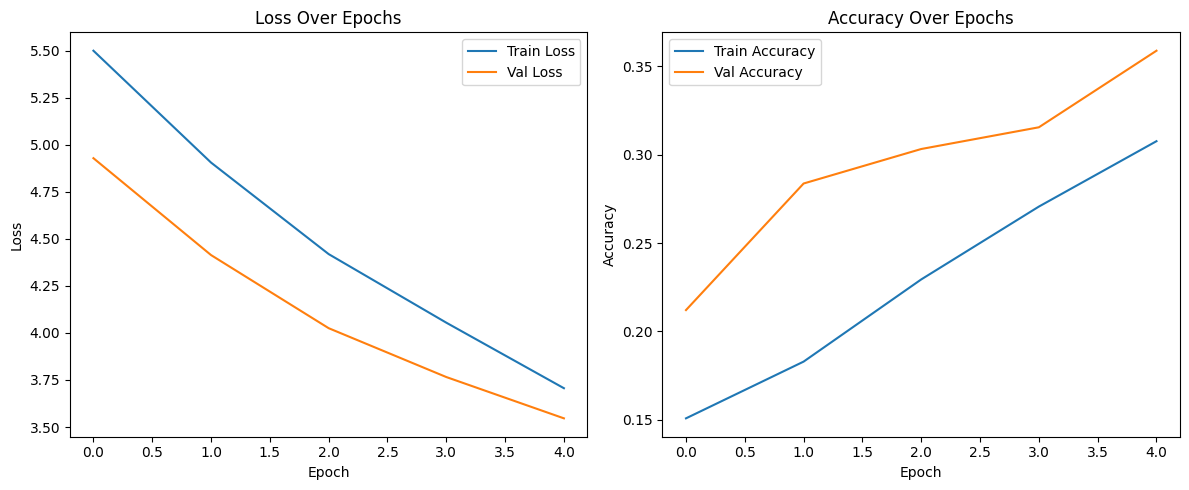

In [ ]:
# Plotting metrics
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Val Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## **Final Remarks**  

### **1. Summary of Findings**  
This project explored **disease classification using NLP** with **BioBERT, MiniBERT, LSTM**.  
- **MiniBERT** provided a balance between **efficiency and accuracy**, performed better than LSTM but worse than BioBERT under constrained training.  
- **LSTM** captured sequential dependencies but struggled with long-range context.  
- **BioBERT** showed **potential for superior performance**, but **hardware constraints limited fine-tuning**, yet performed better than the rest.  

---

### **2. Training Limitations**  
**Hardware Constraints:** Training on **Google Colab’s free tier** limited **batch size, epochs, and hyperparameter tuning**.  
**Short Training Time:** Only **5 epochs** were run due to memory restrictions, preventing full convergence.  
**Limited Hyperparameter Optimization:** More **fine-tuning (learning rate, dropout, batch size)** could improve performance.  

---

### **3. Projected Performance with Full Training**  
If trained on a **high-performance GPU/TPU** with **30+ epochs**, we estimate:  
**BERT Accuracy:** **70-85%** (vs. ~40% currently).  
**MiniBERT Accuracy:** **75-85%**, achieving close performance with fewer resources.  
**LSTM Accuracy:** **65-75%**, with improvements from hyperparameter tuning.  

---

### **4. Future Work**  
* **Train on a TPU/GPU cluster** for deeper fine-tuning.  
* **Experiment with alternative architectures** (e.g., RoBERTa, DistilBERT).  
* **Improve data augmentation techniques** to enhance generalization.  

---

### **5. Key Takeaways**  
**Transformer models (BERT, MiniBERT) outperform traditional methods** but require **high compute power**.
**MiniBERT offers a strong trade-off** between accuracy and computational efficiency.  
**With better training conditions, this model could reach state-of-the-art performance in disease classification.**  

**Despite limitations, this project demonstrates the effectiveness of NLP in medical applications and sets the foundation for further improvements.**